# 1. 라이브러리 호출 및 데이터 읽기

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import json

from tqdm import tqdm

In [2]:
DATA_IN_PATH = './data/word2vec-nlp-tutorial/'
DATA_OUT_PATH = './data/word2vec-nlp-tutorial/data_out/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [3]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [4]:
train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

# 2. 모델 하이퍼파라미터 정의

In [5]:
model_name = 'rnn_classifier_en'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_dimension': 100,
        'dropout_rate': 0.2,
        'lstm_dimension': 150,
        'dense_dimension': 150,
        'output_dimension':1}

# 3. 모델 선언 및 컴파일

In [6]:
class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(RNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['dense_dimension'],
                           activation=tf.keras.activations.tanh)
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [7]:
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

## callback 선언

In [8]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data/word2vec-nlp-tutorial/data_out/rnn_classifier_en -- Folder already exists 



# 4. 모델 학습

In [9]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
176/176 [==============================] - 327s 2s/step - loss: 0.6932 - accuracy: 0.5033 - val_loss: 0.6929 - val_accuracy: 0.5096

Epoch 00001: val_accuracy improved from -inf to 0.50960, saving model to ./data/word2vec-nlp-tutorial/data_out/rnn_classifier_en\weights.h5
Epoch 2/5
176/176 [==============================] - 298s 2s/step - loss: 0.6915 - accuracy: 0.5177 - val_loss: 0.4860 - val_accuracy: 0.7576

Epoch 00002: val_accuracy improved from 0.50960 to 0.75760, saving model to ./data/word2vec-nlp-tutorial/data_out/rnn_classifier_en\weights.h5
Epoch 3/5
176/176 [==============================] - 351s 2s/step - loss: 0.3949 - accuracy: 0.8297 - val_loss: 0.2773 - val_accuracy: 0.8844

Epoch 00003: val_accuracy improved from 0.75760 to 0.88440, saving model to ./data/word2vec-nlp-tutorial/data_out/rnn_classifier_en\weights.h5
Epoch 4/5
176/176 [==============================] - 309s 2s/step - loss: 0.1899 - accuracy: 0.9298 - val_loss: 0.2784 - val_accuracy: 0.8888

Ep

# 5. 결과 플롯

In [10]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

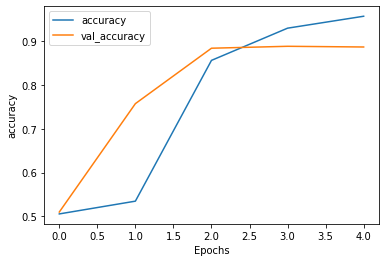

In [11]:
plot_graphs(history, 'accuracy')

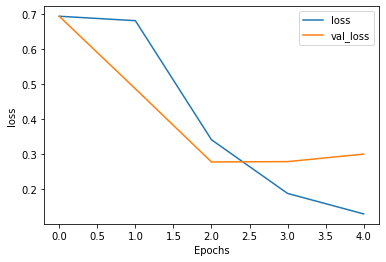

In [12]:
plot_graphs(history, 'loss')

# 6. 테스트

In [13]:
DATA_OUT_PATH = './data/word2vec-nlp-tutorial/data_out/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'


test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

## 베스트 모델 불러오기

In [14]:
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, 'rnn_classifier_en/', SAVE_FILE_NM))

## 테스트 데이터 예측하기

In [15]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

In [16]:
test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(test_id), "sentiment":list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_rnn.csv', index=False, quoting=3)

------

# 점수

0.94403